# ◆[Students Performance in Exams](https://www.kaggle.com/spscientist/students-performance-in-exams)
### 目的：学生のプロフィールから、親の最終学歴を予測をする
- 目的変数を親の最終学歴とする多クラス分類問題としてSoftmax 回帰モデルを構築する
##### Create Date：2020/01/07　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

#### 【手順】
0. [**Notebook内で利用する関数の定義**](#import_module)
1. [**データ読込**](#import_data)
2. [**特徴量の抽出**](#feature_extraction)
3. [**前処理**](#prepearing)
4. [**モデル構築**](#modeling)
5. [**モデル評価**](#model_evaluation)
6. [**テストデータ予測**](#submission)

###### ※データセット「StudentsPerformance.csv」（学習データ数：1000行8列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | gender | 性別 | - | - |
|  2 | race/ethnicity | 人種・民族 | - | ○ |
|  3 | parental level of education | 親の教育レベル | - | ○ |
|  4 | lunch | ランチ | - | - |
|  5 | test preparation course | 試験準備コース | - | ○ |
|  6 | math score | 数学のスコア | - | ○ |
|  7 | reading score | リーディングスコア | - | ○ |
|  8 | writing score | ライティングスコア | - | ○ |

## 0. Notebook内で利用する関数の定義<a id='import_module'></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.linear_model import (LinearRegression,Ridge,Lasso)
# 警告非表示
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 関数：男女別のヒストグラムと歪度
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram(col_name,w,h,bins_val):
    print('\n▼ ' + str(col_name) + 'の分布 ※歪度：',df[col_name].skew())
    plt.figure(figsize=(w,h))
    sns.distplot(df[df['gender']=='male'][col_name],kde=True,rug=False,bins=bins_val,label='male')
    sns.distplot(df[df['gender']=='female'][col_name],kde=True,rug=False,bins=bins_val,label='female')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：指定カラム別にカウント表示するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート有無、xラベルの回転
# ============================================================================
def show_state_count_plot(col_name,col_cnt_name, w, h, sort_flg=False, x_rot = 0):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print('\n▼ ' + str(col_name) + '別の' + str(col_cnt_name) + '数（降順）')
        ax = sns.countplot(df[col_name],hue=df[col_cnt_name],order = df[col_name].value_counts().index)
    else:
        print('\n▼ ' + str(col_name) + '別の' + str(col_cnt_name) + '数')
        ax = sns.countplot(df[col_name],hue=df[col_cnt_name])
        
    ax.set_title('Count by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Count')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：各スコア平均点を比較するグラフ
# 引数：データ名,グラフの横幅、縦幅、平均値、降順ソート有無、xラベルの回転
# ============================================================================
def show_math_score_barplot(col_name, col_score, w, h, baseline, sort_flg=False, x_rot = 0):
    # stateの平均値が成功率になる（成功率＝成功の件数/全体の件数）
    successrate = pd.DataFrame(df[col_score].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values(col_score, ascending=False) # 成功率の降順
        print('\n▼ ' + str(col_name) + '別の' + str(col_score) + 'の平均点（降順）')
    else:
        print('\n▼ ' + str(col_name) + '別の' + str(col_score) + 'の平均点')
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y=col_score, data=successrate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title(str(col_score) + ' by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Ratio')
    plt.show()

# 1. データ読込<a id='import_data'><a>

In [2]:
df = pd.read_csv('./StudentsPerformance.csv')

print('\n▼ データ数確認')
print('train data shape ---------> ' + str(df.shape))

print("\n▼ 先頭5行表示")
display(df.head(5))

print("\n▼ 基本統計量")
display(df.describe())

#print('\n▼ 欠損データ確認')
#display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))


▼ データ数確認
train data shape ---------> (1000, 8)

▼ 先頭5行表示


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75



▼ 基本統計量


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


# 2. 特徴量の抽出<a id='feature_extraction'></a>
## 2-1. 相関関係の確認


▼ 散布図行列（最終学歴別に色分け）


<Figure size 432x288 with 0 Axes>

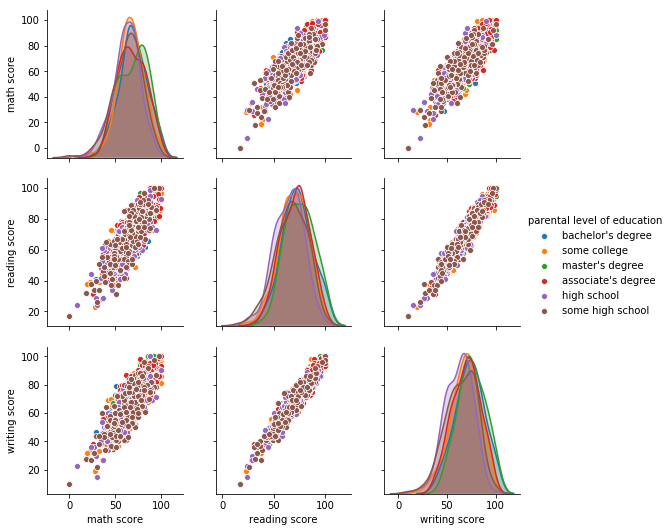

→数学とWriting/Readingよりも、とWritingとReadingが強い。また、男子のほうが数学が得意。

▼ 相関係数をヒートマップにして可視化


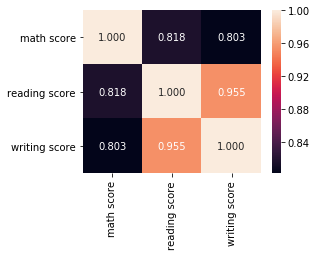


▼ 数学の平均値：
66.089


In [3]:
# 散布図行列
print('\n▼ 散布図行列（最終学歴別に色分け）')
plt.figure(figsize=(6,4))
sns.pairplot(df, hue="parental level of education")
plt.show()
print('→数学とWriting/Readingよりも、とWritingとReadingが強い。また、男子のほうが数学が得意。')

# ヒートマップ
print('\n▼ 相関係数をヒートマップにして可視化')
plt.figure(figsize=(4,3))
sns.heatmap(df.corr(), annot=True, fmt='1.3f')
plt.show()

print('\n▼ 数学の平均値：')
baseline = df['math score'].mean()
print(baseline)

## 2-2. parental level of educationの確認


▼ 目的変数parental level of educationの種類（%）


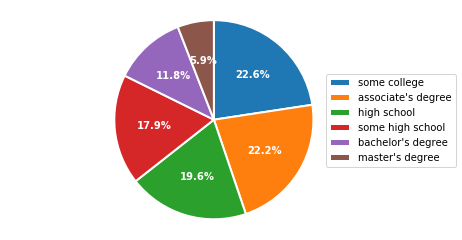

some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental level of education, dtype: int64

In [4]:
print('\n▼ 目的変数parental level of educationの種類（%）')
per_state = round(df['parental level of education'].value_counts() / len(df['parental level of education']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

# カラムの値
display(df['parental level of education'].value_counts())

#大学中退、短大卒、高卒、高校中退、学士卒、修士卒
dic_p = {"some high school": 0, # 高校中退
         "high school": 1, # 高卒
         "some college": 2, # 大学中退
         "associate's degree": 3, # 短大卒
         "bachelor's degree": 4, # 学士卒
         "master's degree":5 # 修士卒
        }

df['parental level of education'] = df['parental level of education'].map(dic_p)

## 2-3. parental level of educationごとのスコア


▼ parental level of education別のgender数


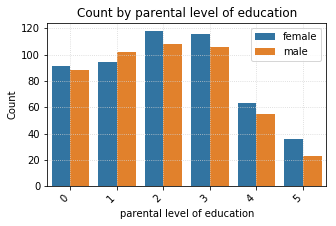


▼ parental level of education別のlunch数


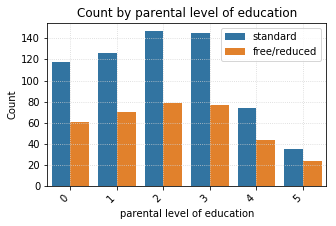


▼ parental level of education別のtest preparation course数


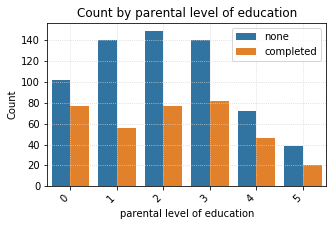


▼ parental level of education別のmath scoreの平均点


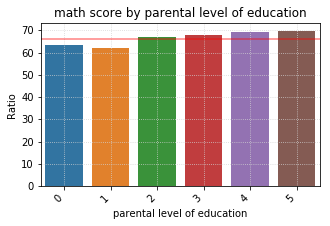


▼ parental level of education別のreading scoreの平均点


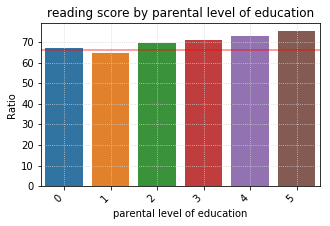


▼ parental level of education別のwriting scoreの平均点


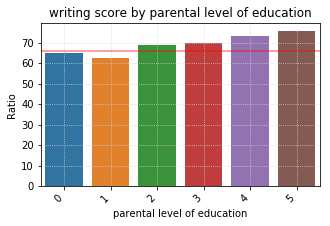

In [5]:
show_state_count_plot('parental level of education','gender',5,3,False,45)
show_state_count_plot('parental level of education','lunch',5,3,False,45)
show_state_count_plot('parental level of education','test preparation course',5,3,False,45)
show_math_score_barplot('parental level of education','math score',5,3,baseline,False,45)
show_math_score_barplot('parental level of education','reading score',5,3,baseline,False,45)
show_math_score_barplot('parental level of education','writing score',5,3,baseline,False,45)


# 3. 前処理<a id='prepearing'></a>
## 3-1.ダミー変換

In [6]:
# ダミー変換
df_dummies = pd.get_dummies(df, columns=['gender', 'race/ethnicity', 'lunch', 'test preparation course'])

print("\n▼ 先頭データ5件")
display(df_dummies.head())


▼ 先頭データ5件


,parental level of education,math score,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,4,72,72,74,1,0,0,1,0,0,0,0,1,0,1
1,2,69,90,88,1,0,0,0,1,0,0,0,1,1,0
2,5,90,95,93,1,0,0,1,0,0,0,0,1,0,1
3,3,47,57,44,0,1,1,0,0,0,0,1,0,0,1
4,2,76,78,75,0,1,0,0,1,0,0,0,1,0,1


# 4. モデル構築<a id='modeling'></a>


▼ some high schoolの重みの大きさを横棒グラフで表示


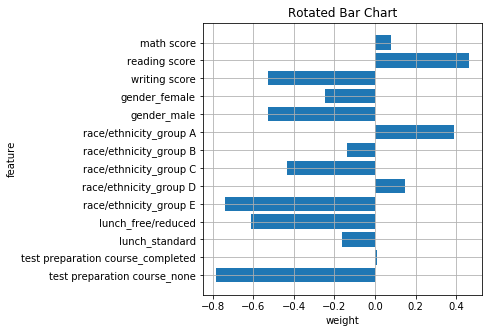


▼ high schoolの重みの大きさを横棒グラフで表示


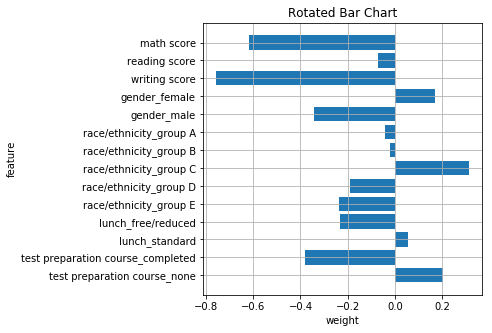


▼ some collegeの重みの大きさを横棒グラフで表示


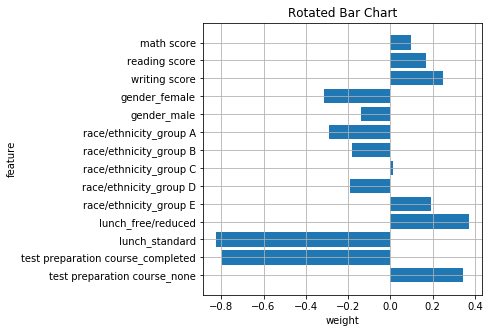


▼ associate's degreeの重みの大きさを横棒グラフで表示


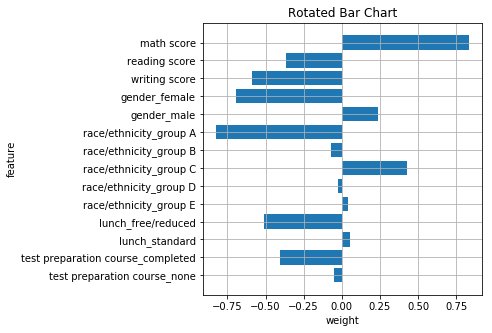


▼ bachelor's degreeの重みの大きさを横棒グラフで表示


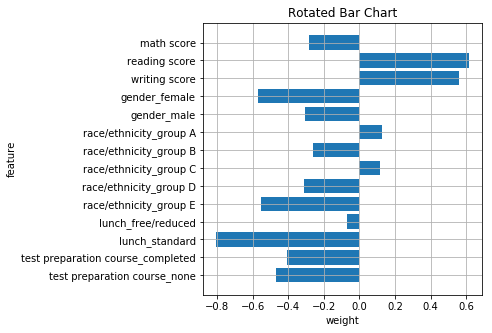


▼ master's degreeの重みの大きさを横棒グラフで表示


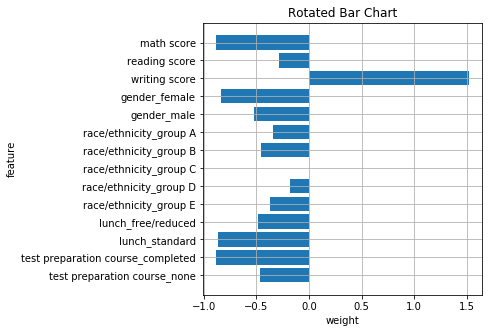

In [7]:
X = df_dummies.drop('parental level of education', axis=1).values # 説明変数
y = df_dummies['parental level of education'].values              # 目的変数

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1234)

scaler = StandardScaler()

# データを標準化
X_train_norm = X_train
X_test_norm = X_test

# 先頭3列を標準化
X_train_norm[:,:3] = scaler.fit_transform(X_train[:,:3])
X_test_norm[:,:3] = scaler.transform(X_test[:,:3])

# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X_train_norm, y_train)

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','w0','abs_w0',
                               'w1','abs_w1',
                               'w2','abs_w2',
                               'w3','abs_w3',
                               'w4','abs_w4',
                               'w5','abs_w5'])

res_df['feature'] = list(df_dummies.drop('parental level of education', axis=1).columns)
res_df['w0'] = clf.coef_[0, :].tolist() # 重み'
res_df['abs_w0'] = abs(res_df['w0'])
res_df['w1'] = clf.coef_[1, :].tolist() # 重み
res_df['abs_w1'] = abs(res_df['w1'])
res_df['w2'] = clf.coef_[2, :].tolist() # 重み
res_df['abs_w2'] = abs(res_df['w2'])
res_df['w3'] = clf.coef_[3, :].tolist() # 重み
res_df['abs_w3'] = abs(res_df['w3'])
res_df['w4'] = clf.coef_[4, :].tolist() # 重み
res_df['abs_w4'] = abs(res_df['w4'])
res_df['w5'] = clf.coef_[5, :].tolist() # 重み
res_df['abs_w5'] = abs(res_df['w5'])

for k, v in dic_p.items():
    print('\n▼ ' + str(k) + 'の重みの大きさを横棒グラフで表示')
    plt.figure(figsize=(5, 5))
    plt.barh(np.arange(len(res_df['feature']))[::-1], res_df['w' + str(v)], align='center')
    plt.yticks(np.arange(len(res_df['feature']))[::-1], res_df['feature'])
    plt.title('Rotated Bar Chart')
    plt.xlabel('weight')
    plt.ylabel('feature')
    plt.grid()
    plt.show()


# 5. モデル評価<a id='model_evaluation'></a>

In [8]:
y_est = clf.predict(X_test_norm)

print('\n▼ モデルの正解(先頭10件)')
print(y_test[:11])

print('\n▼ モデルの予測結果(先頭10件)')
print(y_est[:11])

# 予測確率を出力
print('\n▼ 結果の予測確率(先頭10件)\n(失敗する確率：成功する確率):')
print(clf.predict_proba(X)[:11].astype(float))

print('\n▼ モデルの評価結果')
# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

print('→非常に精度が悪いです。子供の成績から親の最終学歴を分類するのは難しいのでしょうか。')


▼ モデルの正解(先頭10件)
[1 1 2 0 1 0 1 2 1 4 2]

▼ モデルの予測結果(先頭10件)
[1 3 1 1 1 1 1 1 1 1 3]

▼ 結果の予測確率(先頭10件)
(失敗する確率：成功する確率):
[[2.69239149e-02 4.75041304e-47 3.24356960e-01 5.20446833e-06
  3.24356960e-01 3.24356960e-01]
 [7.16662616e-02 1.50553394e-51 3.09444579e-01 1.64342026e-13
  3.09444579e-01 3.09444579e-01]
 [1.16604866e-01 6.77676837e-59 2.94465028e-01 4.84008075e-08
  2.94465028e-01 2.94465028e-01]
 [2.47922432e-01 1.86334873e-30 2.50923015e-01 2.71813045e-05
  2.50923015e-01 2.50204357e-01]
 [1.16657158e-01 9.35343106e-49 2.94436000e-01 3.48433656e-05
  2.94436000e-01 2.94435999e-01]
 [1.72032002e-01 1.64211744e-48 2.75989331e-01 3.21922293e-09
  2.75989331e-01 2.75989331e-01]
 [1.84558972e-01 2.55754750e-58 2.71813673e-01 1.05648734e-08
  2.71813673e-01 2.71813673e-01]
 [1.12206105e-01 2.03663685e-26 2.95745626e-01 6.27880899e-04
  2.95745626e-01 2.95674762e-01]
 [2.12630099e-02 5.05689392e-43 3.26242982e-01 8.04542069e-06
  3.26242982e-01 3.26242982e-01]
 [2.19698479e-01 7.2091206